In [67]:
import numpy as np
import skimage as sk
from skimage import color, exposure, transform

NUM_CLASSES = 43
IMG_SIZE = 48



In [64]:

### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

def mytransform(img):
    
    # central square crop
    min_side = min(img.shape[:-1])
    
    centre = img.shape[0]//2, img.shape[1]//2
    
    img = img[centre[0] - min_side//2 : centre[0] + min_side//2, 
             centre[1] - min_side//2 : centre[1] + min_side//2]
    
    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))
    # cv2.resize(RGB_img, (32, 32), interpolation = cv2.INTER_CUBIC)
    
    # roll color/channel axis to the front axis 0 
    data = np.rollaxis(img, -1, 0)
    
    return data, img


def preprocess_img_direct(img):
    img = exposure.equalize_hist(img)
    return mytransform(img) 

def preprocess_img(img):
    # transform from rgb to hsv 
    hsv = color.rgb2hsv(img)
    
    # Histogram Equalization for v channel
    hsv[:, :, 2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)
    
    return mytransform(img)
    

/home/davidz/work/anaconda2/envs/carnd-terml/lib/python3.6/site-packages/skimage/exposure/exposure.py:63: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  warn("This might be a color image. The histogram will be "
/home/davidz/work/anaconda2/envs/carnd-terml/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


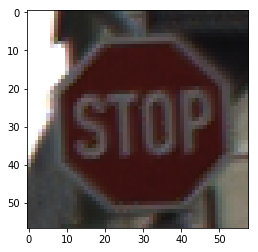

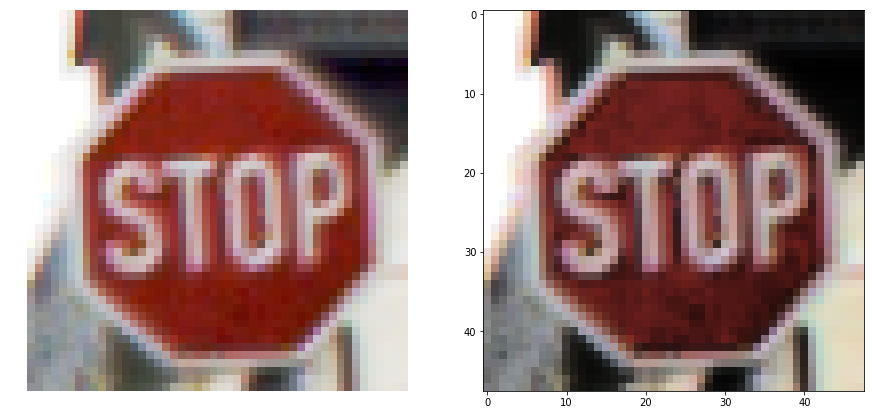

In [65]:

import cv2

def readImg(name):
    img = cv2.imread(name, -1)
    RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # return cv2.resize(RGB_img, (32, 32), interpolation = cv2.INTER_CUBIC)
    return RGB_img

img1 = readImg('./GTSRB/Final_Test/Images/01874.ppm')
img2 = readImg('./GTSRB/Final_Test/Images/01874.ppm')

plt.imshow(img1)

d1, hs1 = preprocess_img_direct(img1)
d2, hs2 = preprocess_img(img2)

fig = plt.figure(figsize = (15, 10))
fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.imshow(hs1)
fig.add_subplot(1,2,2)
plt.imshow(hs2)


In [68]:
# LOAD Training dataset 

from skimage import io
import os
import glob

def get_class(img_path):
    return int(img_path.split('/')[-2])

root_dir = 'GTSRG/Final_Training/Images/'
imgs = []
labels = []

all_img_paths = glob.glob(os.path.join(root_dir,'*/*.ppm'))
np.random.shuffle(all_img_paths)
for img_path in all_img_paths:
    img = preprocess_img(io.imread(img_path))
    label = get_class(img_path)
    imgs.append(img)
    labels.append(label)

X = np.array(imgs, dtype='float32')
y = np.eye(NUM_CLASSES, dtype='uint8')[labels]


In [71]:
# build CNN model 
### try to build the model using Keres

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout, SpatialDropout2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras import backend as K
K.set_image_data_format('channels_first')

keep_prob = 0.8

def cnn_model():
    # build model
    model = Sequential()
    # Conv Layer1: Input = 3 * 48 * 48, Output = 32 * 48 * 48
    model.add(Conv2D(32, kernel_size=(3, 3), 
                     input_shape=(3, IMG_SIZE, IMG_SIZE), 
                     padding='SAME', activation = 'relu'))

    # MaxPooling 32 * 28 * 28 -> 32 * 24 * 24
    model.add(MaxPooling2D((2,2)))

    # add Spatial Dropout2D
    # model.add(SpatialDropout2D(0.1))
    model.add(Dropout(1-keep_prob))
    
    # add Layer2: cnn, maxpooling, dropout, 32*24*24 -> 64 * 12 * 12
    model.add(Conv2D(64, kernel_size=(3,3), 
                    padding='SAME', activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    # model.add(SpatialDropout2D(0.1))
    model.add(Dropout(1-keep_prob))
    
    # add Layer3: cnn, maxpooling, dropout, 64*12*12 -> 128*6*6
    model.add(Conv2D(128, kernel_size=(3,3), 
                    padding='SAME', activation = 'relu'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(1-keep_prob))
    
    # Flatten 400
    model.add(Flatten())
    
    # dense 1 
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    # dense 2
    model.add(Dense(100))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))

    # logits
    model.add(Dense(NUM_CLASSES))
    model.add(Activation('softmax'))

    return model


In [72]:
# compile model
# train the model using SGD + momentum
from keras.optimizers import SGD
lr = 0.01 
sgd = SGD(lr=lr, decay = 1e-6, momentum = 0.9, nesterov=1)
model = cnn_model()
model.compile(loss='categorical_crossentropy', 
             optimizer = sgd, 
             metrics=['accuracy'])

In [ ]:
# Train the model 

def lr_schedule(epoc): 
    return lr * (0.1 ** int(epochs/10))

batch_size = 32
epochs = 30
model.fit(X, y, batch_size = batch_size, 
         epochs = epochs, validation_split = 0.2, 
         callbacks = [LearningRateScheduler(lr_schedule),
                     ModelCheckpoint('model.h5', save_best_only=True)])



In [ ]:
# Evaluate 

import pandas as pd
test = pd.read_csv('GT-final_test_csv', sep=';')

X_test = []
y_test = []

i = 0
for file_name, class_id in zip(list(test['Filename']), list(test['ClassId'])):
    img_path = os.path.join('GTSRB/Final_Test/Images/', file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)

X_test = np.array(X_test)
y_test = np.array(y_test)

# predict and evaluate
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred == y_test)/np.size(y_pred)
print('Test accuracy = {}'.format(acc))



In [ ]:
# Data augmentation 
from keras.preprocessing.image import ImageDataGenerator
from sklearn